In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

In [2]:
import sys
sys.path.insert(0,'vp_class/')

In [3]:
from class_ou import OU, ou_gradient

In [4]:
import pickle

with open('EX02_OU', 'rb') as f:
    true_sde = pickle.load(f)
    obs = pickle.load(f)
    obs_time = pickle.load(f)
    obs_sigma = pickle.load(f)
    sde_sigma = pickle.load(f)

In [5]:
torch.set_default_dtype(torch.float64)

**Note that the diffusion simulation based on Euler-Maruyama results in very smooth plot once dt > 2.**

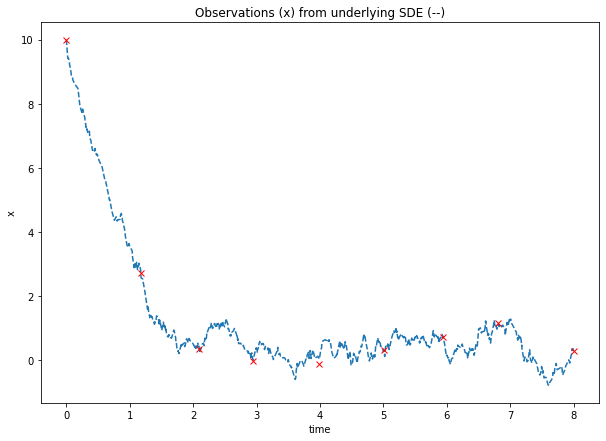

In [6]:
plt.figure(figsize=(10, 7))
plt.title("Observations (x) from underlying SDE (--)")
plt.plot(true_sde.pts.T, true_sde.trj.T, '--')
plt.plot(true_sde.pts[0][::100], obs, 'rx')
plt.xlabel("time")
plt.ylabel("x")
plt.show()

Variational inference: KL

$$ \log\exp\frac{dP^{X}}{dP^{Z}}(Z) = \int_{t_{0}}^{t_{1}}\frac{-Z_{t} + \beta (Z_{t}-\alpha)}{\sigma^{2}}dZ_t - \frac{1}{2} \int_{t_{0}}^{t_{1}} \frac{Z^{2}_{t} - \beta^{2}(Z_{t} - \alpha)^{2}}{\sigma^{2}}dt $$

In [7]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha, self.beta, self.sigma =  ou.alpha, ou.beta, ou.sigma
        
    def KL_Riemann(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma = self.alpha, self.beta, self.sigma

        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        def riemann(z):
            return z * z - beta * beta * ((z - alpha) ** 2)
        
        num = riemann(self.ou.trj)
        
        # re-arrange t so that it starts from 0
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1) 
        return -0.5 * torch.trapezoid(num, x=t).reshape(-1, 1) / (sigma * sigma)
    
    def KL_Ito(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma = self.alpha, self.beta, self.sigma
        
        D = self.alpha.shape[0]
        z0 = self.ou.z0
        z1 = self.ou.trj[:, -1].reshape(D, 1)
        """
            t is tensor
        """
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1) 
        
        t0 = t[:, 0]
        t1 = t[:, -1]

        
        # Obtain the rest 
        def A(u):
            return (beta - 1) * u * u / (2 * sigma * sigma) - alpha * beta * u / (sigma * sigma)

        
        return A(z1) - A(z0) - 0.5 * (beta - 1) * (t1 - t0) 
    
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
        
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


In [8]:
import tqdm as tq

Black box variatioanl inference for SDE

In [9]:
D = 100
S = 80

# If learning rate is high, then beta explodes
learning_rate = 0.0005
lr = learning_rate
IT = 200
dN = 200
z0 = obs[0]
sigma_ = torch.tensor(sde_sigma).repeat(D, 1)
sigma_S = torch.tensor(sde_sigma).repeat(S, 1)

vp_mean = []
vp_std = []
vp_pts = []

elbo_traces = np.empty((len(obs_time) - 1, IT-1))
KL_traces = np.empty((len(obs_time) -1, IT-1))
LL_traces = np.empty((len(obs_time) -1 , IT-1))
pars_traces = np.empty((2, len(obs_time) - 1, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    alpha_ = torch.tensor([1.])
    beta_ = torch.rand(1) + 10
    for i in range(IT):
        alpha_D = alpha_.repeat(D, 1)
        beta_D = beta_.repeat(D, 1)
        z0_D = z0.repeat(D, 1)
        
        # Compute (negative) ELBO
        if i > 0:
            vi_ = OU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, alpha=alpha_D, beta=beta_D, sigma=sigma_, dN=dN, timegrid = 'False')
            elbo_ = ELBO(vi_)
            kl_ = elbo_.KL_Riemann() + elbo_.KL_Ito()
            LL_ = elbo_.log_prob(obs[t+1].repeat(D, 1), obs_sigma)
            elbo_estimate = -1 * (kl_ + LL_)
            elbo_traces[t, i-1] = torch.mean(elbo_estimate).clone()
            KL_traces[t, i-1] = torch.mean(kl_).clone()
            LL_traces[t, i-1] = torch.mean(LL_).clone()
            if i % 50 == 1:
                print("(Neg) elbo = ", torch.nanmean(elbo_estimate).data.numpy())
        # Obtain score function estimator of the gradient
        vi = OU(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, alpha=alpha_D, beta=beta_D, sigma=sigma_, dN=dN, timegrid = 'False')
        elbo = ELBO(vi)
        scores = ou_gradient(vi.pts, vi.trj, torch.stack([alpha_D, beta_D, sigma_]))

#         print("scores = ", scores)
        f_of_X = -1 * (elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma) + elbo.KL_Riemann() + elbo.KL_Ito())
#         print("Ito = ", elbo.KL_ito(), "Rest = ", elbo.KL_rest(), "LL = ", elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma))
#         print("f_of_X = ", torch.nanmean(f_of_X))
#         print("NLL = ", "KL_Ito = ", "KL_rest = ")
        
#         print("scores_beta = ", torch.nanmean(scores['beta']), "scores_alpha = ", torch.nanmean(scores['alpha']))
        alpha_grad = torch.nanmean(f_of_X * scores['alpha'])
        beta_grad = torch.nanmean(f_of_X * scores['beta'])
        
#         print("beta_grad = ", beta_grad, "alpha_grad = ", alpha_grad, "r_grad = ", r_grad)

        # Update the parameter
#         if torch.nanmean(f_of_X) > 1e+6:
#             beta_ -= 0.0000001 * beta_grad
#             alpha_ -= 0.0000001 * alpha_grad
#             r__ = r_ - 0.0000001 * r_grad
#         else:
        beta__ = beta_ - learning_rate * beta_grad
        alpha_ -= learning_rate * alpha_grad

#             It is to ensure r should be strictly positive (i.e. projected gradient method)
        while any(beta__ < 0):
            for d in range(beta_.shape[0]):
                if beta__[d] < 0:
                    while beta__[d] < 0:
                        beta__[d] = beta_[d] + lr * scores['beta'][d]
                        lr *= 0.5
        beta_ = beta__

        pars_traces[0, t, i] = alpha_.clone()
        pars_traces[1, t, i] = beta_.clone()

        
        if i % 50 == 0:
            print("alpha = ", alpha_.data.numpy(), "beta = ", beta_.data.numpy())
        i += 1
#     Compute posteiror mean (based on posterior sample)
    alpha_S = alpha_.repeat(S, 1)
    beta_S = beta_.repeat(S, 1)
    
    posterior = OU(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0.repeat(S, 1), alpha = alpha_S, beta = beta_S, sigma = sigma_S, dN = dN, timegrid='False')
    
    
    if t > 0:
        post_mean_ = posterior.trj.mean(axis=0)[1:]
        post_std_ = posterior.trj.std(axis=0)[1:]
        post_pts_ = posterior.pts.mean(axis=0)[1:]
    else:
        post_mean_ = posterior.trj.mean(axis=0)
        post_std_ = posterior.trj.std(axis=0)
        post_pts_ = posterior.pts.mean(axis=0)
    
    vp_mean.append(post_mean_.clone().data.numpy())
    vp_std.append(post_std_.clone().data.numpy())
    vp_pts.append(post_pts_.clone().data.numpy())
#     z0 = torch.tensor(obs[t+1])
    z0 = post_mean_.clone()[-1]
#     print("posterior_mean = ", z0)
# score.compute_score()

  0%|                                                     | 0/8 [00:00<?, ?it/s]

alpha =  [0.59477485] beta =  [10.50760623]
(Neg) elbo =  413.5617632290635
alpha =  [2.85511596] beta =  [9.96554013]
(Neg) elbo =  93.12469241685771
alpha =  [2.98193283] beta =  [9.65203979]
(Neg) elbo =  87.84059272864253
alpha =  [3.06428262] beta =  [9.34731732]
(Neg) elbo =  85.25091149323558


 12%|█████▋                                       | 1/8 [00:13<01:33, 13.40s/it]

alpha =  [0.93266147] beta =  [10.80618206]
(Neg) elbo =  29.37415399109542
alpha =  [0.51274093] beta =  [10.77188905]
(Neg) elbo =  16.954997458646098
alpha =  [0.46926352] beta =  [10.73767924]
(Neg) elbo =  16.785951180400023
alpha =  [0.49314593] beta =  [10.69443771]
(Neg) elbo =  16.409922889833133


 25%|███████████▎                                 | 2/8 [00:26<01:20, 13.35s/it]

alpha =  [0.89965743] beta =  [10.51048399]
(Neg) elbo =  43.56975719282515
alpha =  [0.04463078] beta =  [10.51004559]
(Neg) elbo =  3.8781840192870396
alpha =  [-0.00046623] beta =  [10.50813504]
(Neg) elbo =  3.363706268848494
alpha =  [-0.00804103] beta =  [10.5073336]
(Neg) elbo =  3.3351616965860638


 38%|████████████████▉                            | 3/8 [00:40<01:06, 13.33s/it]

alpha =  [0.92590212] beta =  [10.29510062]
(Neg) elbo =  61.485004553715456
alpha =  [-0.01595143] beta =  [10.29489643]
(Neg) elbo =  2.914999730483129
alpha =  [-0.11319398] beta =  [10.29451556]
(Neg) elbo =  3.0148995468204784
alpha =  [-0.11331577] beta =  [10.29374389]
(Neg) elbo =  3.5777355255839516


 50%|██████████████████████▌                      | 4/8 [00:53<00:53, 13.33s/it]

alpha =  [0.97300024] beta =  [10.34336125]
(Neg) elbo =  28.201611792515333
alpha =  [0.33861786] beta =  [10.34185438]
(Neg) elbo =  3.5626398695658956
alpha =  [0.28893499] beta =  [10.33979879]
(Neg) elbo =  3.864042673793987
alpha =  [0.29276952] beta =  [10.33779176]
(Neg) elbo =  3.783853446625414


 62%|████████████████████████████▏                | 5/8 [01:06<00:40, 13.36s/it]

alpha =  [0.98392617] beta =  [10.60214075]
(Neg) elbo =  7.736499915937357
alpha =  [0.73640555] beta =  [10.60129031]
(Neg) elbo =  3.612200235392389
alpha =  [0.69441883] beta =  [10.60022776]
(Neg) elbo =  3.9431338911233507
alpha =  [0.68778376] beta =  [10.598445]
(Neg) elbo =  3.700735947676622


 75%|█████████████████████████████████▊           | 6/8 [01:20<00:26, 13.35s/it]

alpha =  [1.01295788] beta =  [10.37790513]
(Neg) elbo =  4.967711463483155
alpha =  [1.10994121] beta =  [10.37689134]
(Neg) elbo =  3.9601605210739756
alpha =  [1.14322169] beta =  [10.37647316]
(Neg) elbo =  3.857237199779552
alpha =  [1.12342971] beta =  [10.37571549]
(Neg) elbo =  3.864602716375685


 88%|███████████████████████████████████████▍     | 7/8 [01:33<00:13, 13.34s/it]

alpha =  [0.92361651] beta =  [10.54173538]
(Neg) elbo =  24.093123846535722
alpha =  [0.34186233] beta =  [10.539638]
(Neg) elbo =  4.3969602843787445
alpha =  [0.30686381] beta =  [10.53569605]
(Neg) elbo =  4.951727684794718
alpha =  [0.31599904] beta =  [10.52973775]
(Neg) elbo =  4.62422679776582


100%|█████████████████████████████████████████████| 8/8 [01:46<00:00, 13.34s/it]


Trace plot: ELBO

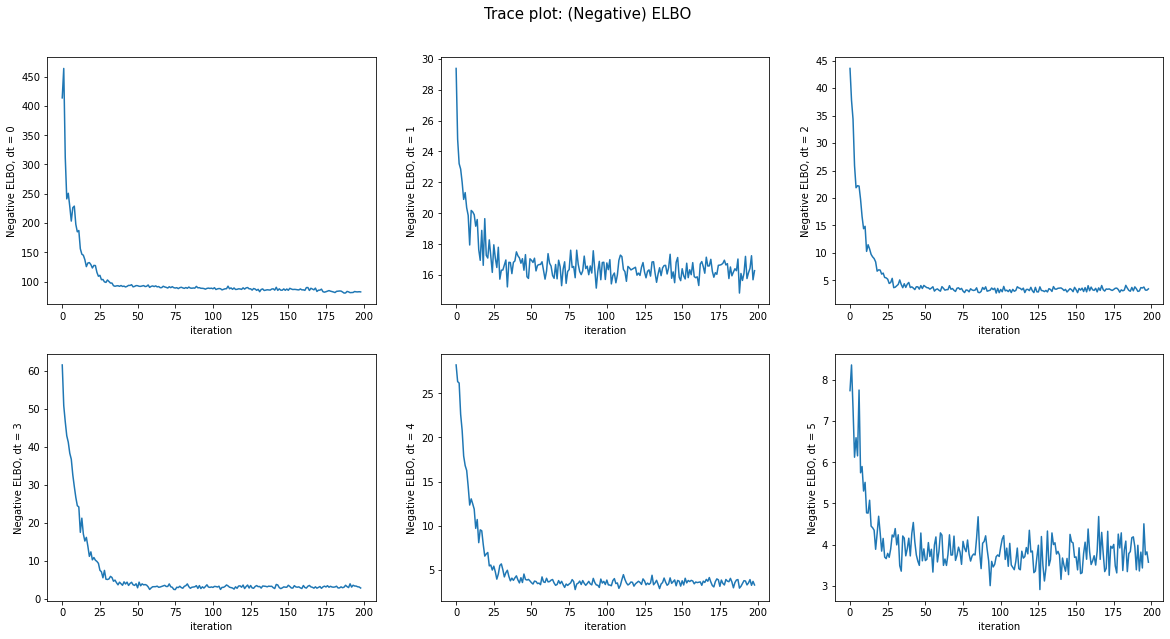

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(elbo_traces[t, :])), elbo_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

Trace plot: KL divergence

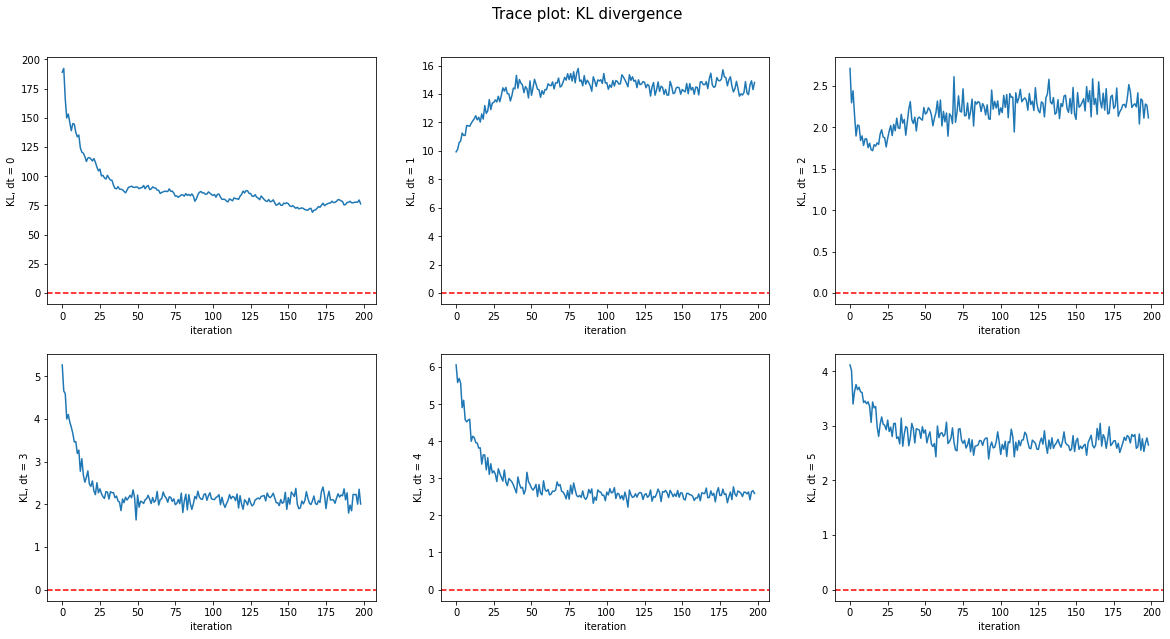

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(KL_traces[t, :])), -1 * KL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("KL, dt = %d" % t)
    ax.axhline(0, color='red', linestyle='dashed')
    t += 1
    
plt.suptitle("Trace plot: KL divergence", size=15, y=0.95)
plt.show()

Trace plot: NLL

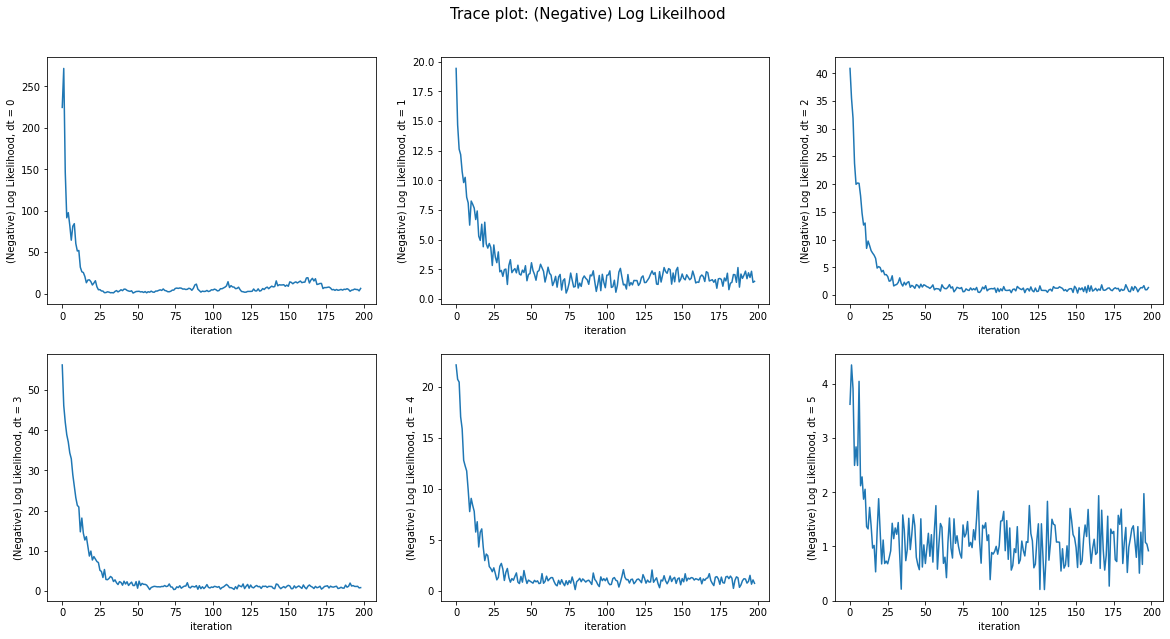

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
t = 0
for ax in ax.ravel():
    ax.plot(np.arange(len(LL_traces[t, :])), -1 * LL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("(Negative) Log Likelihood, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) Log Likeilhood", size=15, y=0.95)
plt.show()

Trace plot: parameters

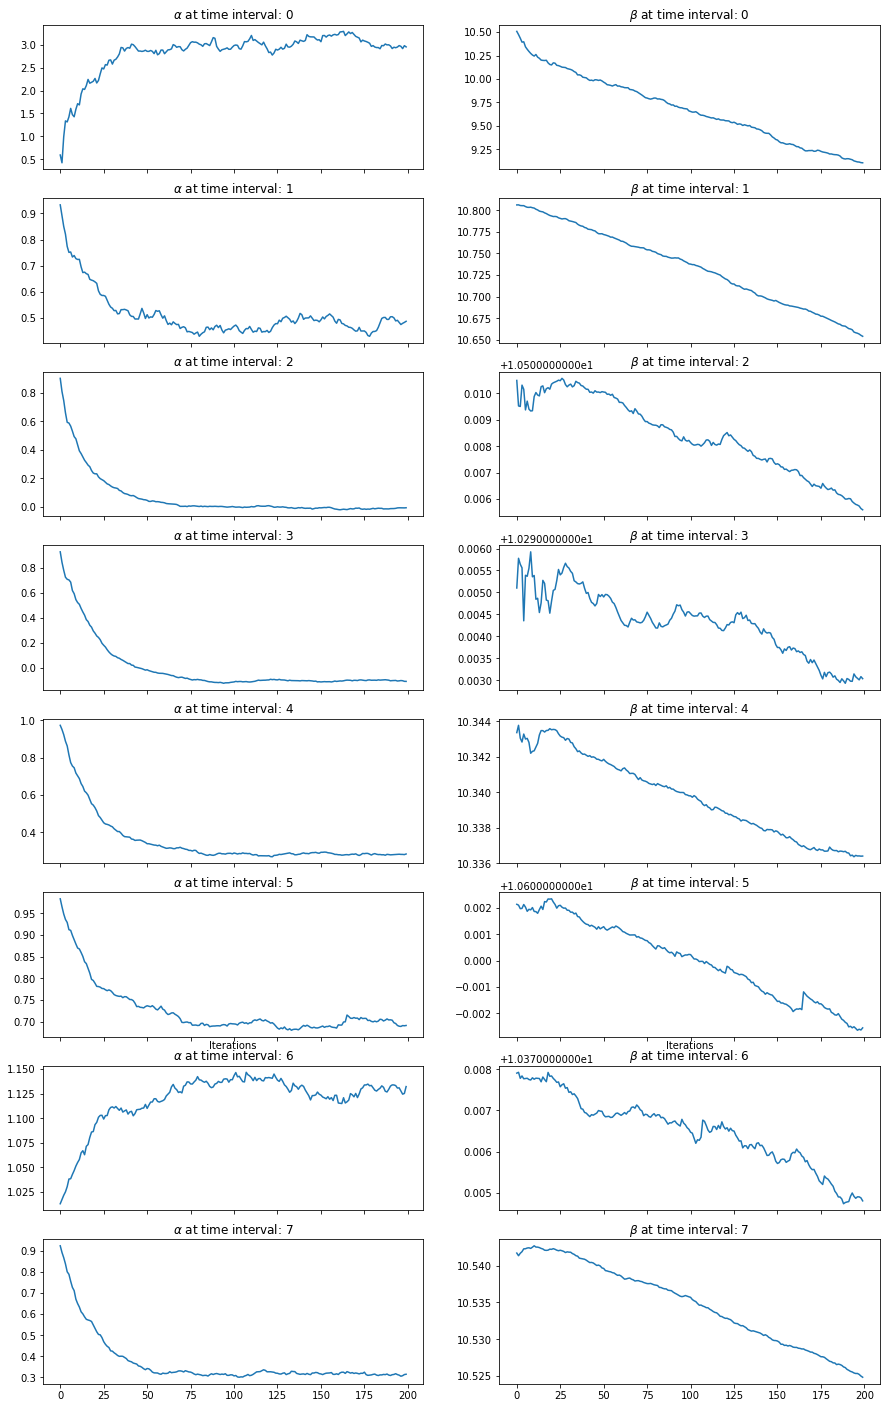

In [13]:
fig, ax = plt.subplots(nrows=pars_traces.shape[1], ncols=2, figsize=(15, 25), sharex='all')
names = [r'$\alpha$', r'$\beta$']
for j, ax in enumerate(ax.ravel()):
    i = j % 2
    t = j // 2
    ax.plot(np.arange(pars_traces[i, t, :].shape[0]), pars_traces[i, t, :])
    ax.set_title(names[i] + " at time interval: %d" % t)
#     ax.set_yticks(np.linspace(0,2,10))
    if t == 5:
        ax.set_xlabel("Iterations")
plt.show()

**Posterior approximation**

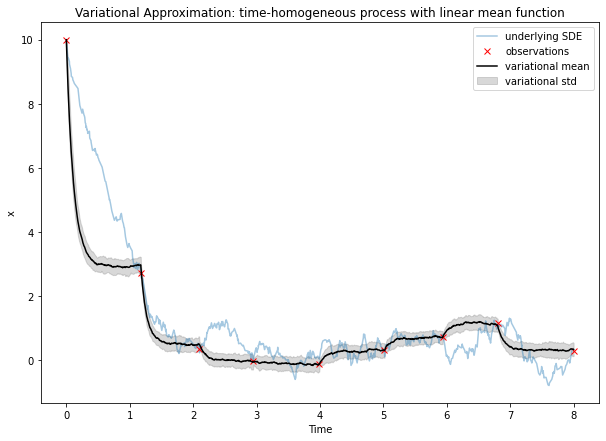

In [14]:
vi_mean = np.concatenate(vp_mean)
vi_var = np.concatenate(vp_std)
vi_pts = np.concatenate(vp_pts)

plt.figure(figsize=(10, 7))
plt.plot(true_sde.pts.T, true_sde.trj.T, label="underlying SDE", alpha=0.4)
plt.plot(obs_time, obs, 'rx', label='observations')
plt.plot(vi_pts, vi_mean, color='black', label='variational mean')
plt.fill_between(vi_pts, vi_mean + vi_var, vi_mean - vi_var, alpha=0.3, color='grey', label='variational std')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Variational Approximation: time-homogeneous process with linear mean function")
plt.show()